In [ ]:
import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)



import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wandb
from modules.utils import load_runs_final_artifact
from modules.models import TCN_channel, TCN, memory_polynomial_channel
from modules.utils import *
import pandas as pd
import seaborn as sns



DEVICE = torch.device("cpu")
print("DEVICE", DEVICE)
ENTITY = "dylanbackprops-university-of-washington"
PROJECT = "mldrivenpeled"

DEVICE cpu


In [3]:
# Set plotting variables

plt.rcParams.update({
    'font.size': 8,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica'],
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 100,
    'lines.linewidth': 1.0,
    'lines.markersize': 4,
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'axes.linewidth': 0.8, 
})

c_tcn = '#0072B2'
c_mp = '#D55E00'


In [4]:
models = {
    "48mA": {
        'ofdm_info': extract_zarr_data( "..\data\channel_measurements\zarr_files\channel_3e5-7.6MHz_2.68.V_0.125A_48mA_scale2_dynamic_power_0.5-3_v2.zarr", DEVICE),
        'tcn_channel': "avid-sweep-24",
        'encoder_decoder_tcn': "blank",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'blank'
    },
        "60mA": {
        'ofdm_info': extract_zarr_data( "..\data\channel_measurements\zarr_files\channel_3e5-9.2MHz_2.775.V_0.129A_60ma_scale2_dynamic_power_0.5-3.zarr", DEVICE),
        'tcn_channel': "snowy-sweep-4",
        'encoder_decoder_tcn': "blank",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'blank'
    }
}

c:\Users\maild\mldrivenpeled\modules\utils.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cache_path, map_location=device)


Loaded from cache!
Loaded from cache!


In [5]:

# Iterate over different current levels and fit memory polynomial models
for current_level, model_info in models.items():
    ofdm_info = model_info['ofdm_info']
    mp_model = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2, device=torch.device('cpu'))
    _, _ , _ = mp_model.fit(ofdm_info.sent_frames_time, ofdm_info.received_frames_time)
    model_info['memory_polynomial'] = mp_model

In [6]:
mp_48 = models['48mA']['memory_polynomial']
X = models['48mA']['ofdm_info'].sent_frames_time
Y = models['48mA']['ofdm_info'].received_frames_time
mp_48.calculate_err(X, Y, plot=True)

--------------------------------------------------
Rank  | Term String          | ERR (%)        
--------------------------------------------------
1     | x[0]                 | 47.035908%
2     | x[-1]                | 20.079689%
3     | x[-2]                | 10.752263%
4     | x[-3]                | 4.129066%
5     | x[-4]                | 2.429717%
6     | x[0]^2               | 1.972157%
7     | x[-5]                | 1.580471%
8     | x[-6]                | 1.144179%
9     | x[-1]^2              | 0.951849%
10    | x[-7]                | 0.784258%
11    | x[-4]^2              | 0.577479%
12    | x[-5]^2              | 0.556859%
13    | x[-8]                | 0.485650%
14    | x[-6]^2              | 0.391645%
15    | x[-9]                | 0.327004%
16    | x[-3]^2              | 0.246958%
17    | x[-10]               | 0.235725%
18    | x[-7]^2              | 0.219389%
19    | x[-8]^2              | 0.147221%
20    | x[-9]^2              | 0.104858%
21    | x[-2]^2             

(['x[0]',
  'x[-1]',
  'x[-2]',
  'x[-3]',
  'x[-4]',
  'x[-5]',
  'x[-6]',
  'x[-7]',
  'x[-8]',
  'x[-9]',
  'x[-10]',
  'x[0]^2',
  'x[-1]^2',
  'x[-2]^2',
  'x[-3]^2',
  'x[-4]^2',
  'x[-5]^2',
  'x[-6]^2',
  'x[-7]^2',
  'x[-8]^2',
  'x[-9]^2',
  'x[-10]^2'],
 tensor([47.0359, 20.0797, 10.7523,  4.1291,  2.4297,  1.5805,  1.1442,  0.7843,
          0.4857,  0.3270,  0.2357,  1.9722,  0.9518,  0.0978,  0.2470,  0.5775,
          0.5569,  0.3916,  0.2194,  0.1472,  0.1049,  0.0704]))

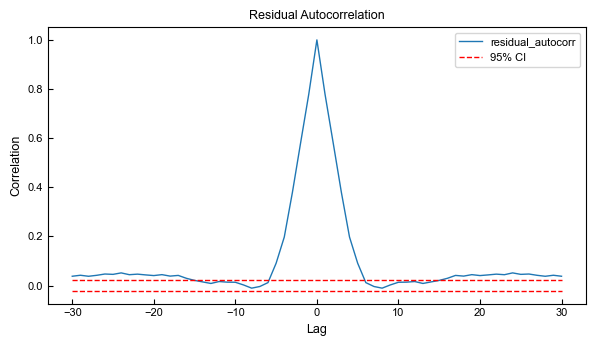

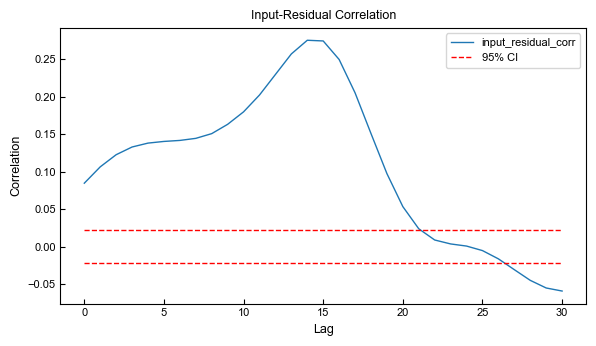

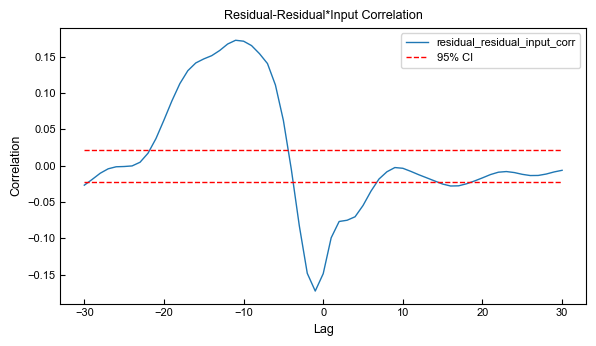

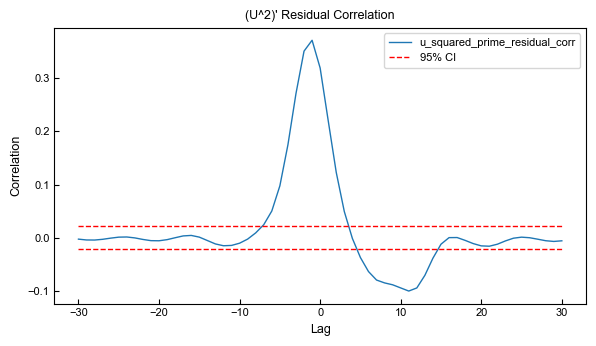

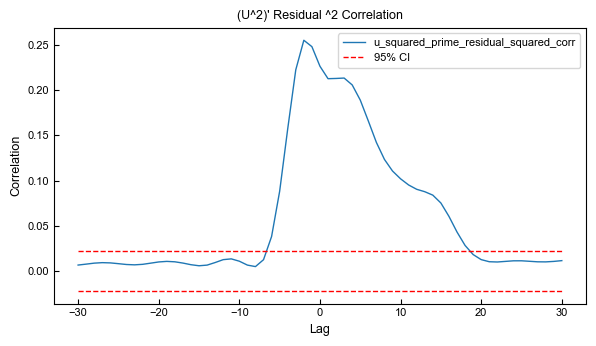

In [7]:
weights, A, r = mp_48.fit(X, Y)
Y_pred = mp_48(X)
compute_billings_corrs(r, Y_pred, lag_max=30)

Loading from ../models\channel_models\avid-sweep-24\channel_model_final.pth


c:\Users\maild\mldrivenpeled\modules\utils.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(local_weights_path, map_location="cpu")


Loading from ../models\channel_models\snowy-sweep-4\channel_model_final.pth


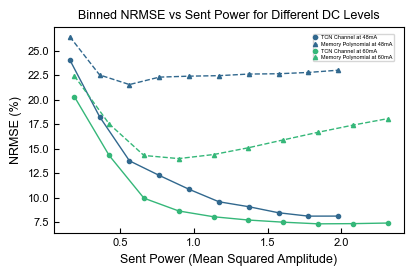

In [8]:
# G2 Plot

# Create scale of colors for different current levels
current_levels = list(models.keys())
num_levels = len(current_levels)
color_palette = sns.color_palette("viridis", num_levels)

    # Make one large figure with binned NRMSE for each current level
plt.figure(figsize=(4, 2.8))
for current_level, model_info in models.items():
    ofdm_info = model_info['ofdm_info']
    X = ofdm_info.sent_frames_time.to(DEVICE)
    Y = ofdm_info.received_frames_time.to(DEVICE)
    mp_model = model_info['memory_polynomial']
    tcn_model, tcn_cfg = load_runs_final_artifact(model_info['tcn_channel'], DEVICE, model_type='channel')



    # Divide into N power bins and compare NRMSE
    N = 10
    sent_powers = X.square().mean(dim=-1)
    pwr_min = sent_powers.min()
    pwr_max = sent_powers.max()

    bins = torch.linspace(pwr_min, pwr_max, N + 1)
    bin_ids = torch.bucketize(sent_powers, bins)
    binned_losses = torch.zeros(N, 2)
    for i in range(N):
        mask = bin_ids == i
        if mask.any():
            filtered_x = X[mask]
            filtered_y = Y[mask]
            noisy_y_pred, y_pred_tcn, std_y_pred, nu_y_pred = tcn_model(filtered_x)
            tcn_rmse_loss = calculate_rmse_pct_loss(filtered_y, y_pred_tcn)
            mp_y_pred = mp_model(filtered_x)
            mp_rmse_loss = calculate_rmse_pct_loss(filtered_y, mp_y_pred)
            binned_losses[i, 0] = tcn_rmse_loss
            binned_losses[i, 1] = mp_rmse_loss
        else:
            binned_losses[i, 0] = torch.nan
            binned_losses[i, 1] = torch.nan

    # Plot binned losses
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.plot(bin_centers.cpu(), binned_losses[:, 0].cpu(), color=color_palette[current_levels.index(current_level)], marker='o', markersize=3, linestyle='-', label=f'TCN Channel at {current_level}')
    plt.plot(bin_centers.cpu(), binned_losses[:, 1].cpu(), color=color_palette[current_levels.index(current_level)], marker='^', markersize=3, linestyle='--', label=f'Memory Polynomial at {current_level}')           

plt.title("Binned NRMSE vs Sent Power for Different DC Levels")
plt.xlabel("Sent Power (Mean Squared Amplitude)")
plt.legend(
    fontsize=4,
    handlelength=0.5,
    labelspacing=0.3,
    borderpad=0.2,
    loc="best",
    bbox_to_anchor=(0.98, 0.98)
)
plt.tight_layout()
plt.ylabel("NRMSE (%)")
plt.show()        


C:\Users\maild\AppData\Local\Temp\ipykernel_17820\768288683.py:52: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


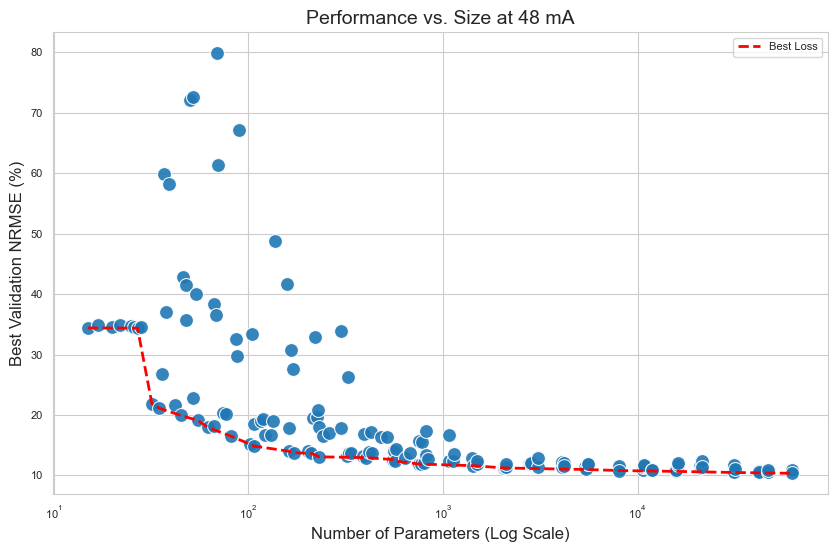

In [36]:
# Get Models for a Sweep and Plot Best Val NMRSE loss vs parameter count

def plot_sweep_pareto(sweep_id, entity, project):
    """
    Fetches all runs from a W&B sweep and plots Best Val NRMSE vs Parameter Count.
    
    Args:
        sweep_id (str): The ID of the sweep.
        entity (str): Your W&B username or team name.
        project (str): The project name.
    """
    api = wandb.Api()

    path = f"{entity}/{project}/{sweep_id}" 
    sweep = api.sweep(path)


    sweep_data = []
    
    for run in sweep.runs:
        # Skip failed/crashed runs
        if run.state != "finished":
            continue
        num_params = run.config.get('num_params')
        
        val_nrmse = run.summary.get('avg_nrmse_pct_loss')
    
        sweep_data.append({
            "params": num_params,
            "nrmse_pct": val_nrmse,
            "run_name": run.name
        })

    df = pd.DataFrame(sweep_data)
    
    df = df.sort_values("params")
    
    pareto_points = []
    current_min_error = float('inf')

    for _, row in df.iterrows():
        if row['nrmse_pct'] < current_min_error:
            pareto_points.append(row)
            current_min_error = row['nrmse_pct']
            
    pareto_df = pd.DataFrame(pareto_points)

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Scatter all runs
    sns.scatterplot(
        data=df, 
        x='params', 
        y='nrmse_pct', 
        s=100, 
        alpha=0.9, 
        palette="deep"
    )
    
    # Draw Pareto Line
    plt.plot(
        pareto_df['params'], 
        pareto_df['nrmse_pct'], 
        color='red', 
        linestyle='--', 
        linewidth=2, 
        label='Best Loss'
    )
    
    plt.xscale('log')
    plt.xlabel('Number of Parameters (Log Scale)', fontsize=12)
    plt.ylabel('Best Validation NRMSE (%)', fontsize=12)
    plt.title('Performance vs. Size at 48 mA', fontsize=14)
    plt.legend(loc='upper right')
    
    
    plt.show()


SWEEP_ID = "yqzp2ezq"

plot_sweep_pareto(SWEEP_ID, entity=ENTITY, project=PROJECT)

In [ ]:
# Analyze Experimental Validation Data
validations = {
    "dazzling-leaf-8110": {
        "encoder_decoder": "scarlet-spaceship-8109"
    }
}

root_val_path = os.path.abs(os.path.join(project_root, "data/validation_measurements"))
for val in validations.keys():
    data_path = os.path.join(root_val_path, f"{val}.zarr")
    data = extract_zarr_data(data_path, device=torch.device('cpu'))

Loading from ../models\channel_models\avid-sweep-24\channel_model_final.pth
Is model Gaussian? False
Mean Nu Prediction at power 0.50: 50.0000
Mean Nu Prediction at power 0.78: 50.0000
Mean Nu Prediction at power 1.06: 50.0000
Mean Nu Prediction at power 1.33: 50.0000
Mean Nu Prediction at power 1.61: 50.0000
Mean Nu Prediction at power 1.89: 50.0000
Mean Nu Prediction at power 2.17: 50.0000
Mean Nu Prediction at power 2.44: 50.0000
Mean Nu Prediction at power 2.72: 50.0000
Mean Nu Prediction at power 3.00: 50.0000


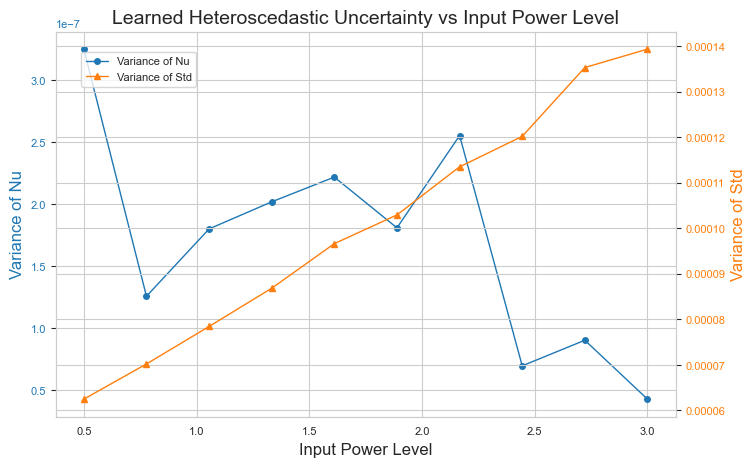

In [34]:
tcn, _ = load_runs_final_artifact(models['48mA']['tcn_channel'], DEVICE, model_type='channel')

print(f"Is model Gaussian? {tcn.gaussian}")
fig, ax1 = plt.subplots(figsize=(8, 5))

power_levels = torch.linspace(0.5, 3.0, steps=10)
nu_variances = []
std_variances = []

with torch.no_grad():
    for power in power_levels:
        input_signal = torch.randn(16, 1000).to(DEVICE) * torch.sqrt(power)
        noisy_y_pred, y_pred_tcn, std_y_pred, nu_y_pred = tcn(input_signal)

        print(f"Mean Nu Prediction at power {power.item():.2f}: {nu_y_pred.mean().item():.4f}")
        var_nu_y_pred = torch.var(nu_y_pred, dim=1).mean(dim=0).cpu().item()
        var_std_y_pred = torch.mean(std_y_pred**2, dim=1).mean(dim=0).cpu().item()
        nu_variances.append(var_nu_y_pred)
        std_variances.append(var_std_y_pred)

ax1.plot(power_levels.cpu(), nu_variances, marker='o', label='Variance of Nu', color='tab:blue')
ax1.set_xlabel('Input Power Level', fontsize=12)
ax1.set_ylabel('Variance of Nu', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(power_levels.cpu(), std_variances, marker='^', label='Variance of Std', color='tab:orange')
ax2.set_ylabel('Variance of Std', fontsize=12, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Learned Heteroscedastic Uncertainty vs Input Power Level', fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
plt.show()

In [ ]:
# Visualize Learned Probability Distribution with Q-Q plot
